In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2ba7a94a115a1c93c6ac634adbba855a8570718cdd71bbfdd9ec9b95704c9a96
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!pip install pyarrow

In [3]:

!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.3 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=ca6ff8523b172a341212a673b174549a4babfc659c16b4647fa24d8b755a5911
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=0401f4d997a3aeaf3170ffdd061aca6a496839b9ce7a39925139ed93307707a0
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found existing 

In [4]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=43a927cc66ccb021ac36a2bbc696850656df5b99df7b80d4f0e162f06fceda6a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from yahoo_fin import stock_info as si
import datetime as dt
from pyspark.ml import Pipeline
import pandas
import pandas_datareader as pdr
from pyspark.sql.functions import year, month, dayofmonth, col
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from pyspark.sql.functions import last, first, coalesce
from pyspark.sql.functions import col, max as max_, min as min_
from pyspark.sql.functions import year, month, dayofmonth, col
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.window import Window

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [6]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [7]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.13.0


In [8]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [49]:
#Setting parameters for data collection

ticker = 'TSLA'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2023, 1, 1)
fred_symbols = ['UNRATE', 'GDP', 'FEDFUNDS', 'CPIAUCNS', 'M2', 'DGS10', 'PCE', 'T10Y2Y', 'USROA', 'USROE', 'WTISPLC', 'HOUST', 'INDPRO', 'PAYEMS', 'BAMLH0A0HYM2', 'GS10', 'BASE', 'RIFSPPFAAD01NB', 'EXUSEU', 'NETEXP']

In [50]:
#Calling APIs to gather information

historical_data = si.get_data(ticker, start_date, end_date, interval='1d')
fred_df = pdr.get_data_fred(fred_symbols, start_date, end_date)

In [51]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

In [52]:
#Dataframe building
historical_data_spark = spark.createDataFrame(historical_data.reset_index())
fred_df_spark = spark.createDataFrame(fred_df.reset_index())

In [53]:
#Performing operations on dataframe through SparkSQL methods

historical_data_spark = historical_data_spark.withColumnRenamed("index", "DATE")
historical_data_spark = historical_data_spark.drop('ticker')

historical_data_spark = historical_data_spark.withColumn("year", year("DATE"))
historical_data_spark = historical_data_spark.withColumn("month", month("DATE"))
historical_data_spark = historical_data_spark.withColumn("day", dayofmonth("DATE"))

historical_data_spark.show()

+-------------------+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+
|               DATE|              open|              high|               low|             close|          adjclose|   volume|year|month|day|
+-------------------+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+
|2010-06-29 00:00:00|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|1.5926669836044312|281494500|2010|    6| 29|
|2010-06-30 00:00:00|1.7193330526351929|2.0280001163482666| 1.553333044052124|1.5886670351028442|1.5886670351028442|257806500|2010|    6| 30|
|2010-07-01 00:00:00|1.6666669845581055|1.7280000448226929|1.3513330221176147|1.4639999866485596|1.4639999866485596|123282000|2010|    7|  1|
|2010-07-02 00:00:00|1.5333329439163208|1.5399999618530273|  1.24733304977417|1.2799999713897705|1.2799999713897705| 77097000|2010|    7|  2|
|2010-

In [54]:
#Indexing dataframe
fred_df_spark = fred_df_spark.withColumn("Index", monotonically_increasing_id())
#fred_df_spark.show()

In [55]:
#Performing joining of the two dataframes on DATE, ordering and removing column

dataset_spark = historical_data_spark.join(fred_df_spark, on="DATE", how="left")
dataset_spark = dataset_spark.orderBy("DATE")
dataset_spark = dataset_spark.withColumn("Index", monotonically_increasing_id())
dataset_spark = dataset_spark.drop("DATE")
dataset_spark.show()

+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|          adjclose|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|1.5926669836044312|281494500|2010|    6| 29|   

In [56]:
#Filling NaN values with the last non-null number

from pyspark.sql.window import Window
import pyspark.sql.functions as F

def forwardFillImputer(df, cols=[], partitioner="Index", value='NaN'):
    for c in cols:
        # Define the window specification with the partitioner
        window_spec = Window.orderBy(partitioner)

        # Replace value with NULL
        df = df.withColumn(c, F.when(F.col(c) != value, F.col(c)).otherwise(F.lit(None)))

        # Forward fill using the last non-null value within the partition
        df = df.withColumn(c, F.last(c, True).over(window_spec))

    return df

In [57]:
dataset_spark = forwardFillImputer(dataset_spark, cols=[i for i in fred_symbols])
dataset_spark.show()

+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|              open|              high|               low|             close|          adjclose|   volume|year|month|day|UNRATE|      GDP|FEDFUNDS|CPIAUCNS|    M2|DGS10|    PCE|T10Y2Y|USROA|USROE|WTISPLC|HOUST| INDPRO|  PAYEMS|BAMLH0A0HYM2|GS10|    BASE|RIFSPPFAAD01NB|EXUSEU|  NETEXP|Index|
+------------------+------------------+------------------+------------------+------------------+---------+----+-----+---+------+---------+--------+--------+------+-----+-------+------+-----+-----+-------+-----+-------+--------+------------+----+--------+--------------+------+--------+-----+
|1.2666670083999634|1.6666669845581055|1.1693329811096191|1.5926669836044312|1.5926669836044312|281494500|2010|    6| 29|  N

In [58]:
# Drop rows where 'column1' or 'column2' have null values
dataset_spark = dataset_spark.dropna()
row_count = dataset_spark.count()

print("Number of rows in the DataFrame: ", row_count)

Number of rows in the DataFrame:  3142


In [59]:
#Data splitting and scaling
test_size = 2513 #0.8
X_train_raw = dataset_spark.toPandas()[:-test_size]
X_test_raw = dataset_spark.toPandas()[-test_size:]

#Standardize
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

# Normalize both features and labels
min_Scaler = MinMaxScaler()
X_train_raw = min_Scaler.fit_transform(X_train_raw)
X_test_raw = min_Scaler.transform(X_test_raw)

In [60]:
window = 400
stride = 25

In [1]:
def build_sequences(df, window=200, stride=20, telescope=1):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    temp_label = df.copy()
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [62]:
target_labels = dataset_spark.columns
telescope = 20

In [63]:
X_train, y_train = build_sequences(X_train_raw, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, window, stride, telescope)
print(X_train.shape)

(16, 400, 30)


In [64]:
def build_LSTM_model(input_shape, output_shape):

    #ENCODER
    encoder_inputs = tfkl.Input(shape=input_shape)
    conv_outputs = tfkl.Conv1D(128, 3, padding='same', activation='relu')(encoder_inputs)
    maxpool_outputs = tfkl.MaxPool1D()(conv_outputs)
    encoder_outputs1 = tfkl.Bidirectional(tfkl.LSTM(256,return_sequences = True, return_state=True))(maxpool_outputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tfkl.Bidirectional(tfkl.LSTM(128, return_state=True))
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    #DECODER
    decoder_inputs = tfkl.RepeatVector(output_shape[0])(encoder_outputs2[0])
    decoder_l1 = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(decoder_l1,initial_state = encoder_states2)
    dropout_l = tfkl.Dropout(0.2)(decoder_l2)
    decoder_outputs2 = tfkl.TimeDistributed(tfkl.Dense(output_shape[1], activation='relu'))(dropout_l)

    #CREATION OF THE MODEL
    model = tf.keras.models.Model(encoder_inputs, decoder_outputs2)

    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    return model

In [65]:
input_shape = (window, 30)
output_shape = (telescope, 30)

batch_size = 128
epochs = 100

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 400, 30)]            0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 400, 128)             11648     ['input_3[0][0]']             
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 200, 128)             0         ['conv1d_2[0][0]']            
 g1D)                                                                                             
                                                                                                  
 bidirectional_8 (Bidirecti  [(None, 200, 512),           788480    ['max_pooling1d_2[0][0]'

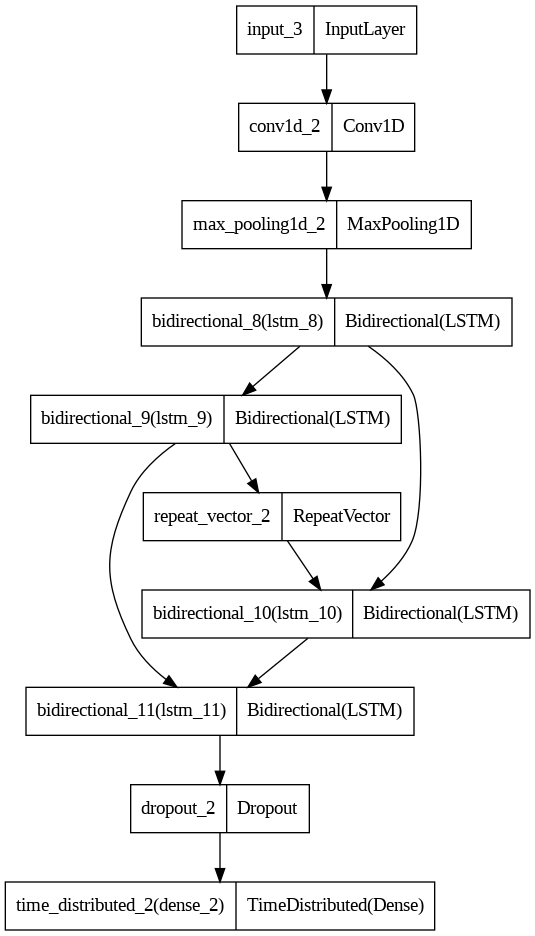

In [66]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [67]:
loss = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
)

model.save('model_cnn_lstm_dropout_400_25_20')

Epoch 1/100
1/1 [==============================] - 24s 24s/step - loss: 0.3030 - mse: 0.3030 - val_loss: 0.2415 - val_mse: 0.2415 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 222ms/step - loss: 0.1321 - mse: 0.1321 - val_loss: 0.1531 - val_mse: 0.1531 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 216ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1158 - val_mse: 0.1158 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 180ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.1192 - val_mse: 0.1192 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 203ms/step - loss: 0.0707 - mse: 0.0707 - val_loss: 0.0900 - val_mse: 0.0900 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 216ms/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0733 - val_mse: 0.0733 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 211ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0708 - val_mse: 0.0708 - lr: 

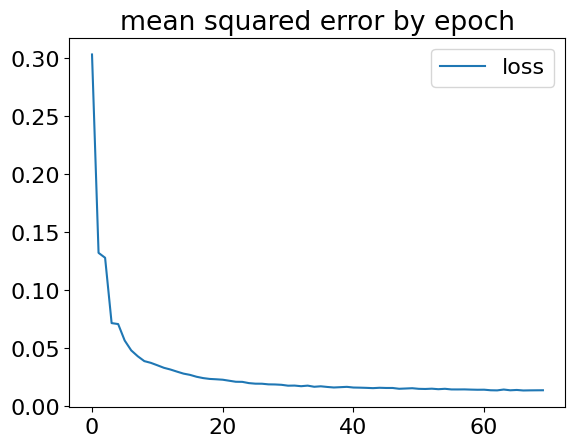

In [68]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

To visualize the predictions

In [69]:
predicted = model.predict(X_test)

3/3 [==============================] - 2s 33ms/step


In [70]:
combined_array = np.concatenate((y_test, predicted), axis = 1)
print(combined_array[:,0,0].shape)

(96,)


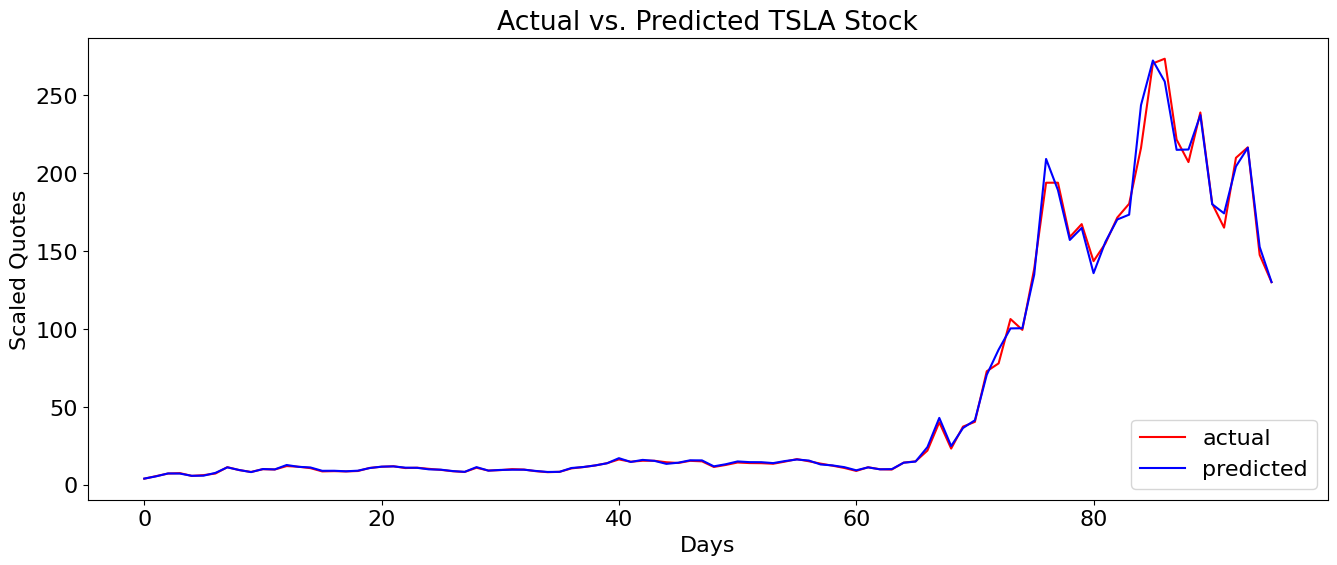

In [71]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0,3],color='red', label='actual')
plt.plot(combined_array[:,1,3],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs. Predicted TSLA Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()